## BlackSheep Cookbook Take 1

The Black Sheep Analysis allows researchers to find trends in abnormal protein enrichment among patients in CPTAC datasets. In this Cookbook, we will go through the steps needed to perform a full Black Sheep Analysis, to answer a research question, of if BMI, age, or country of origin play a role in protein enrichments for patients with Endometrial Cancer.

### Step 1a: Import Dependencies and Choose Omics Table
First, import the necessary dependencies and install cptac through pip.

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install cptac
import cptac
import binarization_functions as bf
import blackSheepCPTACmoduleCopy as blsh
import importlib
importlib.reload(bf)
importlib.reload(blsh)

<module 'blackSheepCPTACmoduleCopy' from 'C:\\Users\\Daniel\\Documents\\GitHub\\WhenMutationsMatter\\Daniel\\blackSheepCPTACmoduleCopy.py'>

## Step 1b: Load Data and Choose Omics Table

In [54]:
en = cptac.Endometrial()
proteomics = en.get_proteomics()
transcriptomics = en.get_transcriptomics()
clinical = en.get_clinical()
phospho = en.get_phosphoproteomics()

Checking that data files are up-to-date...
100% [..................................................................................] 649 / 649
Data check complete.
endometrial data version: 2.1

Loading acetylproteomics data...
Loading clinical data...
Loading CNA data...
Loading definitions data...
Loading miRNA data...
Loading phosphoproteomics_gene data...
Loading phosphoproteomics_site data...
Loading proteomics data...
Loading somatic data...
Loading somatic_binary data...
Loading transcriptomics_circular data...
Loading transcriptomics_linear data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but analysis may not be
published until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter cptac.embargo() to open the webpage for more details.


In [15]:
#Append Genomics_subtype and MSI_status to en.get_clinical()
df= en.get_derived_molecular()
important_things_to_append = ['Genomics_subtype', 'MSI_status']

clinical['Genomics_subtype'] = df['Genomics_subtype']
clinical['MSI_status'] = df['MSI_status']

## Step 2: Determine what attributes you would like to A/B test. 

In [5]:
#Create a subset copy of the original Clinical DataFrame. 
annotations = clinical[['Country', 'BMI', 'Age', 'Histologic_type']].copy()

#Create a dictionary to map replace countries into two options: US or Other
#Key = country to replace
#Value = replacement for key
MSI_map = {'United States':'US', 
              'Ukraine':'Other', 
              'Other_specify':'Other', 
              'Poland':'Other'}

#Using the functions to binarize various different columns
#NOTE: Histologic_type is already binary, and does not need to be binarized
annotations['Country'] = bf.binarizeCategorical(clinical, 'Country', dictionary_map)
annotations['BMI'] = bf.binarizeRange(clinical, 'BMI', 18, 25, 'Healthy', 'Unhealthy')
annotations['Age'] = bf.binarizeCutOff(clinical, 'Age', 60.0, 'Old', 'Young')

In [7]:
#This cell is for reference so that I don't have to keep looking up which columns
#in the clinical dataset are binary and which aren't for testing.

non_binary_columns = ['Country', 'Histologic_Grade_FIGO', 
                      'Proteomics_Tumor_Normal', 'Myometrial_invasion_Specify', 
                      'Path_Stage_Primary_Tumor-pT', 'Path_Stage_Reg_Lymph_Nodes-pN', 
                      'Clin_Stage_Dist_Mets-cM', 'Path_Stage_Dist_Mets-pM', 
                      'tumor_Stage-Pathological', 'FIGO_stage', 'BMI', 'Age', 'Race', 
                      'Ethnicity', 'Tumor_Site', 'Tumor_Site_Other', 'Tumor_Size_cm', 
                      'Num_full_term_pregnancies']

already_binary_columns = ['Treatment_naive', 'Diabetes', 'Gender', 
                          'Tumor_Focality', 'Histologic_type', 
                          'Tumor_purity', 'LVSI']

## Step 3: Perform outliers analysis

In [6]:
outliers = blsh.make_outliers_table(transcriptomics, iqrs=2.0, 
                                  up_or_down='up', aggregate=False, 
                                  frac_table=False)

## Step 4: Wrap your A/B test into the outliers analysis, and create a table

In [18]:
results = blsh.compare_groups_outliers(outliers, annotations, frac_filter=.3)

Testing 9 rows for enrichment in Country Other samples
Testing 49 rows for enrichment in Country US samples
No rows had outliers in at least 0.3 of BMI Unhealthy samples
Testing 262 rows for enrichment in BMI Healthy samples
Testing 14 rows for enrichment in Age Old samples
Testing 59 rows for enrichment in Age Young samples
Testing 2 rows for enrichment in Histologic_type Endometrioid samples
Testing 813 rows for enrichment in Histologic_type Serous samples


## Step 5: Visualize these enrichments

In [19]:
results.head()

,Country_Other_enrichment_FDR,Country_US_enrichment_FDR,BMI_Healthy_enrichment_FDR,Age_Old_enrichment_FDR,Age_Young_enrichment_FDR,Histologic_type_Endometrioid_enrichment_FDR,Histologic_type_Serous_enrichment_FDR
A1BG,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1BG-AS1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1CF,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2M,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2M-AS1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


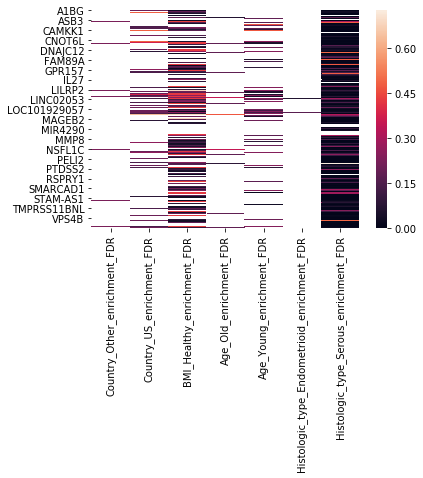

In [20]:
sns.heatmap(results)
plt.show()

## Step 6: Determine significant enrichments, and link with cancer drug database.

In [40]:
#Check for significant columns
for col in results.columns:
    bf.significantEnrichments(results, col, 0.001)

No significant results in Country_Other

No significant results in Country_US

No significant results in BMI_Healthy

No significant results in Age_Old

No significant results in Age_Young

No significant results in Histologic_type_Endometrioid

There are 153 significant proteins enrichments in Histologic_type_Serous:



In [41]:
#Store the dataframe of significant enrichments
sig_results = bf.significantEnrichments(results, 'Histologic_type_Serous_enrichment_FDR', 0.001)

There are 153 significant proteins enrichments in Histologic_type_Serous:



In [53]:
sig_results.head()

,Histologic_type_Serous_P_values
AAR2,0.000143
AATF,0.000028
ABHD8,0.000872
AKAP4,0.000105
AKR1B1,0.000872
